In [1]:
from periodicLatticeSolver import PeriodicLatticeSolver
from minimizer import Minimizer
import numpy as np
from FloorPlanClass import FloorPlan
from plotter import Plotter
PLS = PeriodicLatticeSolver(200, .02, axis='both')
PLS.add_Injector()

L1 = PLS.Variable('L1', varMin=.01, varMax=.5)
L2= PLS.Variable('L2', varMin=.01, varMax=.5)
L3 =PLS.Variable('L3', varMin=.01, varMax=.5)
L4= PLS.Variable('L4', varMin=.01, varMax=.5)

Bp1 = .45
Bp2 = .45
Bp3 = .45
Bp4 = .45

rp1 = PLS.Variable('rp1', varMin=.01, varMax=.03)
rp2 = PLS.Variable('rp2', varMin=.01, varMax=.03)
rp3 = PLS.Variable('rp3', varMin=.01, varMax=.03)
rp4 = PLS.Variable('rp4', varMin=.01, varMax=.03)

r0=PLS.Variable('r0',varMin=1,varMax=1.3)
TL1=PLS.Variable('TL1',varMin=.5,varMax=1.5)
TL2=PLS.Variable('TL2',varMin=.5,varMax=1.5)


PLS.set_Track_Length(TL1=TL1,TL2=TL2)
PLS.begin_Lattice()

PLS.add_Bend(np.pi, r0, .45)
#PLS.add_Drift(L=.03)
PLS.add_Lens(L4, Bp4, rp4)
PLS.add_Drift()
PLS.add_Combiner()
PLS.add_Drift()
PLS.add_Lens(L1, Bp1,rp1)
#PLS.add_Drift(L=.03)
PLS.add_Bend(np.pi, r0, .45)
#PLS.add_Drift(L=.03)
PLS.add_Lens(L2, Bp2, rp2)
PLS.add_Drift()
PLS.add_Lens(L3, Bp3, rp3)
#PLS.add_Drift(L=.03)
PLS.end_Lattice()

Lattice model completed


100%|██████████| 100/100 [02:12<00:00,  1.33s/it]


minCost for each thread:  [1.84142259 1.9        1.84273363 1.79458735 1.9        1.84209423
 1.9        1.9        1.79396754 1.9        1.9        1.9       ]


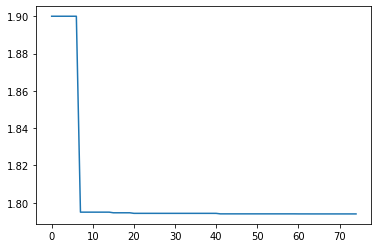

[0.09199521 0.5        0.01       0.01       0.0288251  0.02771364
 0.03       0.01       1.20242955 0.5        1.05489513 0.10428052
 0.06877849 0.05      ] 1.7939675358634743
76 76
percent particles surviving (x,y): 5.0, 5.0
[0.09199521 0.5        0.01       0.01       0.0288251  0.02771364
 0.03       0.01       1.20242955 0.5        1.05489513 0.10428052
 0.06877849 0.05      ] 1.7939675358634743
done
Total time 2 minutes and 12 seconds


In [3]:
minimizer=Minimizer(PLS)
minimizer.find_Global_Min(mut=.75, crossPop=.7, iterations=100, popPerDim=20,strategy='best/1')

[0.092  0.5    0.01   0.01   0.0288 0.0277 0.03   0.01   1.2024 0.5
 1.0549 0.1043]


TypeError: wrapper_module_1.autofunc() missing required argument 's_offset' (pos 3)

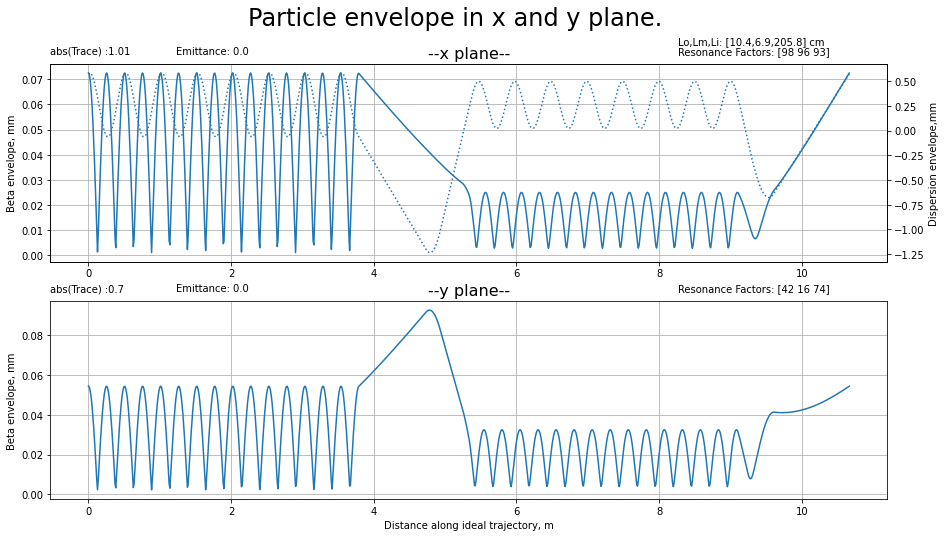

In [4]:
plotter=Plotter(PLS)
plotter.plot(sol=minimizer.sol)

In [ ]:
floorPlan=FloorPlan(PLS)
floorPlan.show_Floor_Plan(sol=minimizer.sol)
floorPlan.calculate_Cost()